## Import libraries

In [1]:
import numpy as np
import os
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pandas as pd

Hardware specification

In [2]:
import tensorflow as tf

def check_gpu():
    print("tf.test.is_built_with_cuda()")
    print(tf.test.is_built_with_cuda())

    print()
    print("tf.config.list_physical_devices('GPU')")
    print(tf.config.list_physical_devices('GPU'))

    print()
    print("tf.config.experimental.list_physical_devices('GPU')")
    print(tf.config.experimental.list_physical_devices('GPU'))

check_gpu() # Google Colab doesn't have a GPU?

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import tensorflow as tf

# Use CPU for training
#tf.config.set_visible_devices([], 'GPU')

# Use GPU for training (if available)
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

# Check the device placement
print("Device:", tf.config.list_logical_devices())

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Enable memory growth for each GPU
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)


Device: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]


#### Google Colab Google Drive mounting

In [ ]:
#drive.mount('/content/drive')

# Set the path to the dataset folder
#data_folder = '/content/drive/MyDrive/data'
data_folder = 'data'

files = os.listdir(data_folder)
for file in files:
    print(file)

train
test
pred


## Data loading and data preparation

Image shape: 150 x 150 x 3
Image size: 16802 bytes
Image data type: uint8
Image color space: RGB


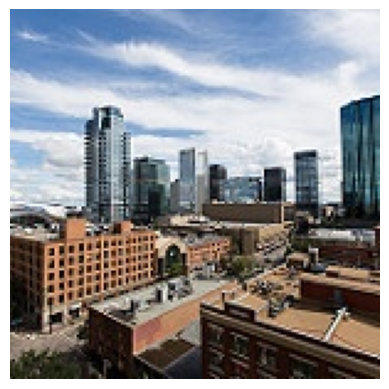

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def get_image_info(image_path):
    image = cv2.imread(image_path)

    if image is not None:
        # Image shape
        height, width, channels = image.shape
        print("Image shape:", height, "x", width, "x", channels)

        # Image size in bytes
        image_size = os.path.getsize(image_path)
        print("Image size:", image_size, "bytes")

        # Image data type
        image_dtype = image.dtype
        print("Image data type:", image_dtype)

        # Image color space
        if channels == 1:
            color_space = "Grayscale"
        elif channels == 3:
            color_space = "RGB"
        else:
            color_space = "Unknown"
        print("Image color space:", color_space)

        # Display the image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    else:
        print("Failed to read the image:", image_path)


get_image_info("data/train/buildings/10006.jpg")


In [ ]:
from sklearn.utils import shuffle
from tqdm import tqdm

class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

def count_images(folder_path):
    count = 0
    for _, _, files in os.walk(folder_path):
        count += len(files)
    return count

train_counts = [count_images(os.path.join(data_folder, 'train', class_name)) for class_name in class_names]
test_counts = [count_images(os.path.join(data_folder, 'test', class_name)) for class_name in class_names]
print("Train Images:", train_counts)
print("Test Images:", test_counts)

train_counts = sum([count_images(os.path.join(data_folder, 'train', class_name)) for class_name in class_names])
test_counts = sum([count_images(os.path.join(data_folder, 'test', class_name)) for class_name in class_names])

print("Total Train Images:", train_counts)
print("Total Test Images:", test_counts)

Train Images: [2191, 2271, 2404, 2512, 2274, 2382]
Test Images: [437, 474, 553, 525, 510, 501]
Total Train Images: 14034
Total Test Images: 3000


### Load images in batches into RAM

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

class My_Custom_Generator(Sequence):
    def __init__(self, folder_path, max_images, batch_size):
        self.folder_path = folder_path
        self.max_images = max_images
        self.batch_size = batch_size
        self.images, self.labels = self.load_images()

    def load_images(self):
        print("Loading " + self.folder_path)
        images = []
        labels = []

        num_images_loaded = 0  # Counter for total images loaded

        # Calculate images per folder based on the total number of folders in the dataset
        images_per_folder = int(self.max_images / len(os.listdir(self.folder_path)))

        for folder in tqdm(os.listdir(self.folder_path)):
            num_images_loaded_this_folder = 0
            if folder not in class_names_label:
                continue
            label = class_names_label[folder]
            # Iterate through each image in this folder
            for file in os.listdir(os.path.join(self.folder_path, folder)):
                if num_images_loaded_this_folder >= images_per_folder:
                    break
                # Get the path name of the image
                img_path = os.path.join(os.path.join(self.folder_path, folder), file)
                # Open the image
                image = imread(img_path)
                image = resize(image, (150, 150, 3))
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                num_images_loaded_this_folder += 1
                num_images_loaded += 1

        print("Loaded " + self.folder_path)
        images, labels = shuffle(images, labels, random_state=3)
        images = np.array(images, dtype='float16') / 255.0
        labels = np.array(labels, dtype='int8')
        labels = tf.keras.utils.to_categorical(labels, num_classes=6)  # Convert labels to one-hot encoding
        return images, labels

    def __len__(self):
        return int(np.ceil(len(self.images) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]
        return batch_images, batch_labels

train_generator = My_Custom_Generator(os.path.join(data_folder, 'train'), max_images=7000, batch_size=64)
test_generator = My_Custom_Generator(os.path.join(data_folder, 'test'), max_images=1750, batch_size=64)
test_labels = test_generator.labels

n_train = train_generator.labels.shape[0]
n_test = test_generator.labels.shape[0]
test_percentage = (n_test / (n_train + n_test)) * 100

print("Train images:", n_train)
print("Test images:", n_test)
print("Test percentage: {}%".format(round(test_percentage)))

print("train_generator.images.shape:", train_generator.images.shape)
print("train_generator.labels[:10]:", train_generator.labels[:10])
print("test_generator.images.shape:", test_generator.images.shape)
print("test_generator.labels[:10]:", test_generator.labels[:10])


Loading data/train


100%|██████████| 6/6 [00:54<00:00,  9.00s/it]


Loaded data/train
Loading data/test


100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


Loaded data/test
Train images: 6996
Test images: 1746
Test percentage: 20%
train_generator.images.shape: (6996, 150, 150, 3)
train_generator.labels[:10]: [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
test_generator.images.shape: (1746, 150, 150, 3)
test_generator.labels[:10]: [[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## Multi-class Classification using Convulotinal Neural Networks (CNNs)

We are using a pre-trained ResNet50 model is used for multi-class image classification. The ResNet50 model is loaded without its top layer and its layers are frozen to prevent them from being trained. A new sequential model is created on top of the base model, consisting of a flatten layer, a dense layer with ReLU activation, and a dense layer with softmax activation for the output. The model is compiled with the Adam optimizer and categorical cross-entropy loss. The training and test images are preprocessed by scaling their values between 0 and 1. The model is then trained using the training images and labels, with a batch size of 32 and for 10 epochs. The validation data is provided using the test images and labels. After training, the model is saved for future use.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from sklearn.utils import shuffle


def train_model(batch_size, architecture='resnet50', learning_rate=0.001):
    # Load the specified base model
    if architecture == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    elif architecture == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    else:
        raise ValueError("Invalid architecture specified. Supported architectures: 'resnet50', 'densenet121'.")

    # Freeze the base model's layers
    # base_model.trainable = False

    # Create a new model on top of the base model
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(6, activation='softmax'))  # Assuming 6 scene classes

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    # Calculate the number of steps (batches) per epoch for training and validation
    train_steps = len(train_generator)
    val_steps = len(test_generator)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=5,
        validation_data=test_generator,
        validation_steps=val_steps
    )

    # Save the model
    model.save('scene_classification_model.h5')

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=val_steps)

    # Print the test accuracy
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    return model, history


## Learning Curve and Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_loss_accuracy(history):
    if not isinstance(history, dict):
        history = history.history

    num_epochs = len(history["accuracy"])
    x_values = range(1, num_epochs + 1)  # Generate x-axis values starting from 1

    # Plot accuracy
    plt.plot(x_values, history['accuracy'], label = "Train acc")
    plt.plot(x_values, history['val_accuracy'], label = "Validation acc")
    plt.title("Learning curve")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.xticks(range(0, num_epochs + 1, 2), range(0, num_epochs + 1, 2))
    plt.show()

    # Plot loss function
    plt.plot(x_values, history['loss'], label = "Train loss")
    plt.plot(x_values, history['val_loss'], label = "Validation loss")
    plt.title("Learning curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.xticks(range(0, num_epochs + 1, 2), range(0, num_epochs + 1, 2))
    plt.show()

def plot_confusion_matrix(model, verbose=1):
    class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street" ]
    preds = model.predict(test_generator, workers=8, verbose=verbose)
    preds_labels = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_labels)
    ax = plt.axes()
    sn.heatmap(cm, annot=True, fmt="d",
               annot_kws={"size": 10},
               xticklabels=class_names,
               yticklabels=class_names, ax = ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

## Load or Save the Model

In [ ]:
from tensorflow.keras.models import load_model
import pickle

def save_model_and_history(model, model_file, history, history_file):
    print("Saving " + model_file + " and history")
    model.save(model_file)
    with open(history_file, 'wb') as hist:
        pickle.dump(history.history, hist)
    print("Saved " + model_file + " and history")

def load_model_and_history(model_file, model_history_file):
    if not os.path.exists(model_file) or not os.path.exists(model_history_file):
        return None, None

    print("Loading model " + model_file + " and history")
    model = load_model(model_file)
    with open(model_history_file, "rb") as hist_file:
        history = pickle.load(hist_file)
    print("Loaded model " + model_file + " and history")

    return model, history

def get_test_acc(model, verbose=1):
    preds = model.predict(test_generator, workers=8, verbose=verbose)
    preds_labels = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_labels)

    sum_diagonal = np.trace(cm)
    acc = sum_diagonal / np.sum(cm)
    return acc

def get_test_accs(model, verbose=1):
    preds = model.predict(test_generator, workers=8, verbose=verbose)
    preds_labels = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_labels)

    accuracies = []
    for i in range(cm.shape[0]):
        tp = cm[i,i]
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + tp
        fn = np.sum(cm[i, :]) - tp
        acc_class = (tp + tn) / (tp+fp+tn+fn)
        accuracies.append(acc_class)

    return accuracies

def evaluate_model(model):
    print("Evaluating on test set...")
    acc = get_test_acc(model, verbose=0)
    print("Test set accuracy: {:.2f}%".format(acc*100))
    accs = get_test_accs(model, verbose=0)
    classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
    for i in range(len(classes)):
        print("Test set accuracy for {}: {:.2f}%".format(classes[i], accs[i]*100))


def train_model_load_save_and_analysis(batch_size, model_file, architecture='resnet50'):

    if architecture == 'resnet50':
        print("Resnet-50 CNN Model")
    elif architecture == 'densenet121':
        print("Densenet-121 CNN Model")
    
    print("batch_size={0}".format(batch_size))

    history_file = model_file[0:-3] + "_history"
    model, history = load_model_and_history(model_file, history_file)
    was_model_loaded = model != None and history != None

    if was_model_loaded:
        evaluate_model(model)
    else:
        # Couldn't load model, so train it now and save it
        model, history = train_model(batch_size=32, architecture='resnet50')
        # model, history = train_model(batch_size=32, architecture='densenet121')
        save_model_and_history(model, model_file, history, history_file)

    plot_confusion_matrix(model, verbose=0)
    plot_loss_accuracy(history)


# Create the models folder if doesnt exist
if not os.path.exists("resnetmodels"):
    os.makedirs("resnetmodels", exist_ok=True)

batch_sizes = [32, 64, 128]
model_file = "resnetmodels/resnetmodel{0}.h5".format(batch_sizes[0])
train_model_load_save_and_analysis(batch_sizes[0], model_file, architecture='resnet50')
# train_model_load_save_and_analysis(batch_sizes[0], architecture='densenet121', model_file)
print()


Resnet-50 CNN Model
batch_size=32


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24,113,798
Trainable params: 24,060,678
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/5


2023-06-21 03:53:34.050402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  1/110 [..............................] - ETA: 1:12:07 - loss: 2.2048 - accuracy: 0.1719

: 

: 

## Code to test if I can get the visual ouput of Feature Extraction

In [ ]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Create an intermediate model to extract feature maps
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)

# Choose an image from your dataset
image = train_generator.images[0]  # Choose an image from the training set

# Preprocess the image
preprocessed_image = train_generator.images[0]  # Preprocess the image if necessary

# Reshape the image to match the input shape of the model
reshaped_image = np.expand_dims(preprocessed_image, axis=0)

# Extract the feature maps using the intermediate model
feature_maps = feature_extractor.predict(reshaped_image)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

# Plot the input feature map
plt.subplot(1, 2, 2)
plt.imshow(feature_maps[0, :, :, 0], cmap='gray')  # Assuming grayscale feature map
plt.title('Input Feature Map')

plt.show()
